In [1]:
# Interact with ERPNEXT database
site_dir = "/home/cole/madrid/sites"
db_name = "cole"
db = "test"
import os

current_dir = os.getcwd()
os.chdir(site_dir)

import frappe

frappe.connect(db, db_name=db_name)
import sys

sys.path.append("/home/cole/madrid/apps/inventory_tools/inventory_tools")

# Documentation

In [2]:
def optimize_route_picklist_debug(item_whs: list, root_warehouse: str) -> list:
	"""Optimize the pick-up route for a list of items.

	This function takes a list of dictionaries, each representing an item along with its warehouse
	location, and returns the list reordered based on an optimized pick-up sequence.

	Expected format of `item_whs`:
	        [
	                {
	                        'item_code': <str>,   # The code identifying the item.
	                        'warehouse': <str>    # The warehouse where the item is located.
	                },
	                ...
	        ]

	Returns:
	        list: A reordered list of dictionaries, optimized for the pick-up route.
	"""

	# Grid
	grid = np.array(
		safe_json_loads(frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["matrix"])
	)

	# Scale
	imaginary_x = grid.shape[1]
	real_x = frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["horizontal"]
	scale = real_x / imaginary_x

	# Create the TSP solver instance.
	g = Grid_TSP(grid, scale=scale)

	root_wh = frappe.get_doc("Warehouse Plan", "All Warehouses - CFC").as_dict()
	dropoff = [g.pos2node((root_wh["pickup_point_x"], root_wh["pickup_point_y"]))]

	# Waypoints
	unique_whs = list({item_wh["warehouse"] for item_wh in item_whs})

	# Build a mapping from warehouse to its coordinate and node.
	warehouse_to_node = {}
	for wh in unique_whs:
		accessible_path = frappe.get_doc("Warehouse", wh).as_dict()["accessible_path"].split(",")
		coordinate = (int(accessible_path[0]), int(accessible_path[1]))
		warehouse_to_node[wh] = g.pos2node(coordinate)
	node_to_warehouse = {node: wh for wh, node in warehouse_to_node.items()}

	# For the TSP solver, create a list of nodes corresponding to each unique warehouse.
	pickup_list = list(warehouse_to_node.values())

	# Solve
	pickup_order, *rest = g.tsp(dropoff, pickup_list, True)

	# Map warehouse name to its order
	warehouse_order_map = {}
	for order_index, node in enumerate(pickup_order):
		wh = node_to_warehouse[node]
		warehouse_order_map[wh] = order_index

	# Sort original item_whs
	sorted_item_whs = sorted(
		item_whs,
		key=lambda item: (warehouse_order_map[item["warehouse"]], item["item_code"], item["qty"]),
	)
	return rest

Method: FIFO
[{'item_code': 'Bayberry', 'qty': 17.0, 'warehouse': 'Fruit Storage 11 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 49 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Bayberry', 'qty': 3.0, 'warehouse': 'Fruit Storage 14 - CFC'}]
Distance: 156.0


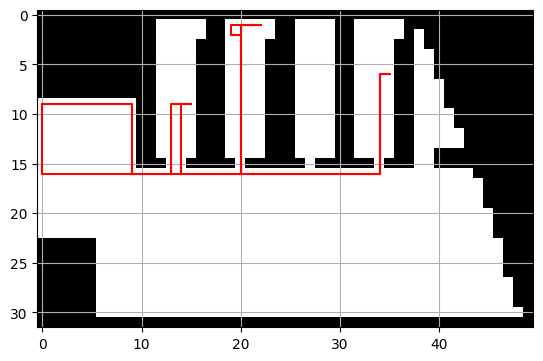

Method: LIFO
[{'item_code': 'Bayberry', 'qty': 20.0, 'warehouse': 'Fruit Storage 57 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 45 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'}]
Distance: 132.0


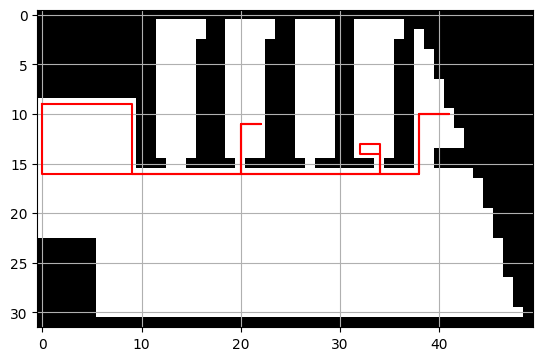

Method: Deplete maximum number of Bins
[{'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 34 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 25 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 21 - CFC'},
 {'item_code': 'Bayberry', 'qty': 10.0, 'warehouse': 'Fruit Storage 11 - CFC'}]
Distance: 152.0


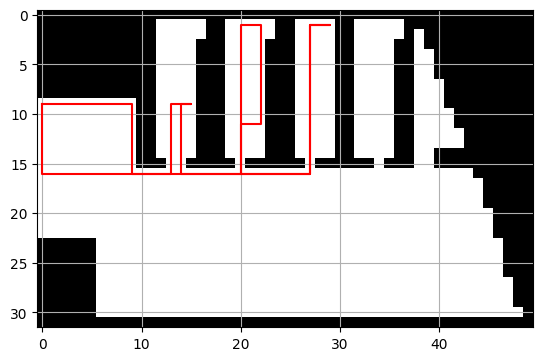

Method: Deplete minimum number of Bins
[{'item_code': 'Bayberry', 'qty': 20.0, 'warehouse': 'Fruit Storage 57 - CFC'},
 {'item_code': 'Kepel', 'qty': 12.0, 'warehouse': 'Fruit Storage 45 - CFC'},
 {'item_code': 'Lychee', 'qty': 3.0, 'warehouse': 'Fruit Storage 49 - CFC'}]
Distance: 134.0


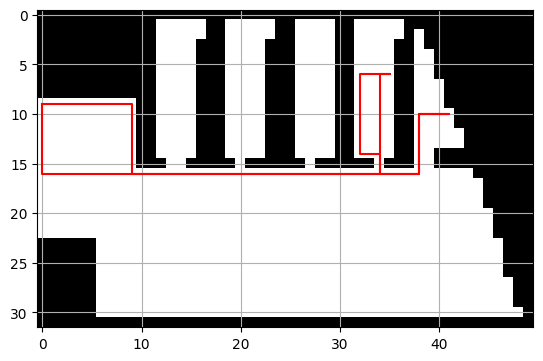

In [3]:
from inventory_tools.inventory_tools.overrides.pick_list import (
    optimize_path,
    optimize_route_picklist,
)
import frappe
from frappe.utils import safe_json_loads
from frappe.utils.data import nowdate
import numpy as np
from inventory_tools.inventory_tools.doctype.warehouse_plan.warehouse_plan import Grid_TSP
from pprint import pprint

methods = [
    "FIFO",
    "LIFO",
    "Deplete maximum number of Bins",
    "Deplete minimum number of Bins",
]
root_warehouse = 'All Warehouses - CFC'
grid = np.array(
    safe_json_loads(frappe.get_doc("Warehouse Plan", root_warehouse).as_dict()["matrix"])
)
for m in methods:
    print(f"Method: {m}")
    optimized = optimize_path("STO-PICK-2025-00001", m)
    pprint(optimized)
    out = optimize_route_picklist_debug(optimized, root_warehouse)
    print(f"Distance: {out[1]}")
    Grid_TSP(grid)._plot(out[0])